<br><font size=64> NSFW CLASSIFIER </font><br><br>
The NSFW Classifier is used to Classify Not safe for work images vs Safe images.<br>
NSFW images includes Porn and Sexy images.<br>
Rest are classified as Safe Images. <br>

This model is hugely inspired by https://www.freecodecamp.org/news/how-to-set-up-nsfw-content-detection-with-machine-learning-229a9725829c/ , https://github.com/GantMan/nsfw_model and his work. Some modification is made and model architecture is changed.<br><br>
The Data for this project is collected with help of scripts at https://github.com/alex000kim/nsfw_data_scraper <br><br>
Mobile Net Architecture is used for the classification as it is very fast and has less params to train.
<br><br>
An ios app is also made and its screen recording is uploaded at https://github.com/lakshaychhabra/NSFW-ios-ML


In [2]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from keras.preprocessing.image import ImageDataGenerator
from keras.backend import clear_session
from keras.optimizers import SGD, Adam
from pathlib import Path
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.models import Sequential, Model, load_model
from keras.layers import Dense, Dropout, Flatten, AveragePooling2D, BatchNormalization
from keras import initializers, regularizers
from pathlib import Path
from keras.callbacks import ModelCheckpoint, TensorBoard, ReduceLROnPlateau, History, LearningRateScheduler
from datetime import datetime
import warnings
warnings.filterwarnings("ignore")
import os
import matplotlib.image as mpimg

Using TensorFlow backend.


In [2]:
!pwd

/home/lakshaychhabralc7/nsfw/data


In [3]:
train_neutral = (len([iq for iq in os.scandir('/home/lakshaychhabralc7/nsfw/data/train/neutral')]))
test_neutral = (len([iq for iq in os.scandir('/home/lakshaychhabralc7/nsfw/data/test/neutral')]))
train_porn = (len([iq for iq in os.scandir('/home/lakshaychhabralc7/nsfw/data/train/porn')]))
train_sexy = (len([iq for iq in os.scandir('/home/lakshaychhabralc7/nsfw/data/train/sexy')]))
test_porn = (len([iq for iq in os.scandir('/home/lakshaychhabralc7/nsfw/data/test/porn')]))
test_sexy = (len([iq for iq in os.scandir('/home/lakshaychhabralc7/nsfw/data/test/sexy')]))

In [4]:
train_data = [train_neutral, train_porn, train_sexy]
test_data = [test_neutral, test_porn, test_sexy]

In [5]:
print("Total number of train data is : ", train_data[0], "+", train_data[1], "+", train_data[2],"=", sum(train_data))
print("Total number of test data is : ", test_data[0], "+", test_data[1], "+", test_data[2],"=", sum(test_data))

Total number of train data is :  34387 + 55581 + 17191 = 107159
Total number of test data is :  2000 + 2000 + 2000 = 6000


In [6]:
train_path =r"/home/lakshaychhabralc7/nsfw/data/train"
test_path = r"/home/lakshaychhabralc7/nsfw/data/test"

So we Have 107k images to train and have 6k images to test

Example of the data Neutral and Sexy category


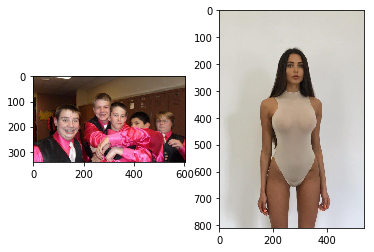

In [7]:
print("Example of the data Neutral and Sexy category")
f, (ax1, ax2) = plt.subplots(1, 2)
img=mpimg.imread(test_path+"/neutral/ffdb5729-8bac-4add-bbc1-41d1e428c842.jpg")
ax1.imshow(img)
img=mpimg.imread(test_path+"/sexy/ffc15b09-10a0-4753-9adf-d38eb53cf8a1.jpg")
ax2.imshow(img)

We need a fast model which gives high accuracy and also have less parsms to train. <br>
We are choosing MobileNet for it.<br>
We will use Transfer Learning and choose weights which were trained for ImageNet.

In [8]:
# As we know the input size in ImageNet was 224 so we have to resize our images accordingly
size = 224
epochs = 100
steps = 500


In [9]:
# We have to take in account different angle of images and to avoid overfit we will use Data Generator, 
# More the Merrier
train_data_generation = ImageDataGenerator(
    rescale=1./255,
    rotation_range=30,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    channel_shift_range=20,
    horizontal_flip=True
)
validation_data_generation = ImageDataGenerator(
    rescale=1./255 #need float values
)

In [10]:
train_generator = train_data_generation.flow_from_directory(
        train_path,
        target_size=(size, size),
        class_mode='categorical',
        batch_size = 64
    )

validation_generator = validation_data_generation.flow_from_directory(
    test_path,
    target_size=(size, size),
    class_mode='categorical',
    batch_size = 64
)

Found 107159 images belonging to 3 classes.
Found 6000 images belonging to 3 classes.


In [11]:
# from keras.backend import clear_session
# clear_session()
# import tensorflow as tf
# from keras.backend.tensorflow_backend import set_session
# config = tf.ConfigProto()
# config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
# sess = tf.Session(config=config)
# set_session(sess)  # set this TensorFlow session as the default session for Keras

## DL Model

In [12]:
conv_m = MobileNetV2(weights='imagenet', include_top=False, input_shape=(size, size, 3))
conv_m.trainable = False
conv_m.summary()

W1016 16:16:39.962056 139796446140160 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W1016 16:16:39.979101 139796446140160 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W1016 16:16:39.984571 139796446140160 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W1016 16:16:40.013334 139796446140160 deprecation_wrapper.py:119] From /usr/local/lib/python3.5/dist-packages/keras/backend/tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W1016 16:16:40.014248 1397964461

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 225, 225, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 112, 112, 32) 864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 112, 112, 32) 128         Conv1[0][0]                      
__________________________________________________________________________________________________
Conv1_relu

In [36]:
model = Sequential()
model.add(conv_m)
model.add(AveragePooling2D(pool_size=(7, 7)))
model.add(Flatten())
model.add(Dense(32, activation = 'relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(3, activation='softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
mobilenetv2_1.00_224 (Model) (None, 7, 7, 1280)        2257984   
_________________________________________________________________
average_pooling2d_5 (Average (None, 1, 1, 1280)        0         
_________________________________________________________________
flatten_7 (Flatten)          (None, 1280)              0         
_________________________________________________________________
dense_19 (Dense)             (None, 32)                40992     
_________________________________________________________________
batch_normalization_7 (Batch (None, 32)                128       
_________________________________________________________________
dropout_11 (Dropout)         (None, 32)                0         
_________________________________________________________________
dense_20 (Dense)             (None, 3)                 99        
Total para

In [11]:
from time import time
filepath = "bestweight.h5"
checkpoint = ModelCheckpoint("weights{epoch:05d}.h5", monitor='val_acc', verbose=1, save_best_only=True, mode='max')
lr_reduce = ReduceLROnPlateau(monitor='val_loss', factor=np.sqrt(0.1), patience=5, verbose=1, cooldown=0, min_lr=0.5e-6)
callbacks = [checkpoint, lr_reduce]



In [ ]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=SGD(lr = 0.1, momentum = 0.9),
    metrics=['accuracy']
)

In [ ]:
# model = load_model("nsfwnsfw_mobilenet2_30.h5")

In [17]:
start = datetime.now()
history = model.fit_generator(
    train_generator,
    callbacks=callbacks,
    epochs=100,
    steps_per_epoch=10,
    validation_data=validation_generator,
    validation_steps=10,
    initial_epoch = 30
)

Epoch 31/100
10/10 [==============================] - 198s 20s/step - loss: 0.3940 - acc: 0.8516 - val_loss: 0.3762 - val_acc: 0.8500

Epoch 00031: val_acc improved from -inf to 0.85000, saving model to weights00031.h5
Epoch 32/100
10/10 [==============================] - 156s 16s/step - loss: 0.4395 - acc: 0.8313 - val_loss: 0.3922 - val_acc: 0.8344

Epoch 00032: val_acc did not improve from 0.85000
Epoch 33/100
10/10 [==============================] - 154s 15s/step - loss: 0.3868 - acc: 0.8641 - val_loss: 0.4182 - val_acc: 0.8406

Epoch 00033: val_acc did not improve from 0.85000
Epoch 34/100
10/10 [==============================] - 153s 15s/step - loss: 0.3991 - acc: 0.8391 - val_loss: 0.4381 - val_acc: 0.8203

Epoch 00034: val_acc did not improve from 0.85000
Epoch 35/100
10/10 [==============================] - 153s 15s/step - loss: 0.3956 - acc: 0.8562 - val_loss: 0.5121 - val_acc: 0.8094

Epoch 00035: val_acc did not improve from 0.85000
Epoch 36/100
10/10 [=====================


Epoch 00072: val_acc did not improve from 0.92344
Epoch 73/100
10/10 [==============================] - 150s 15s/step - loss: 0.2795 - acc: 0.8984 - val_loss: 0.2500 - val_acc: 0.9047

Epoch 00073: val_acc did not improve from 0.92344
Epoch 74/100
10/10 [==============================] - 152s 15s/step - loss: 0.2443 - acc: 0.9016 - val_loss: 0.2477 - val_acc: 0.9000

Epoch 00074: val_acc did not improve from 0.92344
Epoch 75/100
10/10 [==============================] - 152s 15s/step - loss: 0.2644 - acc: 0.9047 - val_loss: 0.2303 - val_acc: 0.9172

Epoch 00075: val_acc did not improve from 0.92344
Epoch 76/100
10/10 [==============================] - 153s 15s/step - loss: 0.2689 - acc: 0.9219 - val_loss: 0.2325 - val_acc: 0.9125

Epoch 00076: val_acc did not improve from 0.92344

Epoch 00076: ReduceLROnPlateau reducing learning rate to 3.1622778103685084e-05.
Epoch 77/100
10/10 [==============================] - 150s 15s/step - loss: 0.2944 - acc: 0.9156 - val_loss: 0.2042 - val_acc: 

OSError: cannot identify image file '/home/lakshaychhabralc7/nsfw/data/train/neutral/ab88dade-237b-44ef-9a13-7c4561325874.jpg'

In [18]:
print("time taken : ", datetime.now() - start)

time taken :  2:58:14.032359


In [19]:
history = model.fit_generator(
    train_generator,
    callbacks=callbacks,
    epochs=100,
    steps_per_epoch=10,
    validation_data=validation_generator,
    validation_steps=10,
    initial_epoch = 78
)

Epoch 79/100
10/10 [==============================] - 165s 17s/step - loss: 0.2313 - acc: 0.9141 - val_loss: 0.2246 - val_acc: 0.9078

Epoch 00079: val_acc did not improve from 0.93590
Epoch 80/100
10/10 [==============================] - 153s 15s/step - loss: 0.2874 - acc: 0.8984 - val_loss: 0.2568 - val_acc: 0.9016

Epoch 00080: val_acc did not improve from 0.93590
Epoch 81/100
10/10 [==============================] - 157s 16s/step - loss: 0.2413 - acc: 0.9219 - val_loss: 0.2424 - val_acc: 0.9141

Epoch 00081: val_acc did not improve from 0.93590
Epoch 82/100
10/10 [==============================] - 153s 15s/step - loss: 0.2711 - acc: 0.9031 - val_loss: 0.2367 - val_acc: 0.9203

Epoch 00082: val_acc did not improve from 0.93590
Epoch 83/100
10/10 [==============================] - 152s 15s/step - loss: 0.2474 - acc: 0.9047 - val_loss: 0.2364 - val_acc: 0.9156

Epoch 00083: val_acc did not improve from 0.93590
Epoch 84/100
10/10 [==============================] - 153s 15s/step - loss:

OSError: cannot identify image file '/home/lakshaychhabralc7/nsfw/data/train/neutral/2e36e378-6e94-4773-a5c0-81a0f9b081fe.jpg'

In [43]:
# model.save("nsfwnsfw_mobilenet2_100.h5")

In [7]:
model = load_model("Final_weights.h5")

W1018 17:14:44.059436 4722533824 deprecation_wrapper.py:119] From /Users/lakshaychhabra/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3980: The name tf.nn.avg_pool is deprecated. Please use tf.nn.avg_pool2d instead.

W1018 17:14:44.198529 4722533824 deprecation.py:506] From /Users/lakshaychhabra/anaconda3/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3445: calling dropout (from tensorflow.python.ops.nn_ops) with keep_prob is deprecated and will be removed in a future version.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
W1018 17:14:50.453603 4722533824 deprecation_wrapper.py:119] From /Users/lakshaychhabra/anaconda3/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W1018 17:14:50.626837 4722533824 deprecation.py:323] From /Users/lakshaychhabra/anaconda3/lib/python3.7/site-packa

In [93]:
import coremltools
model.author = "Lakshay Chhabra"
model.short_description = "NSFW Image Classifier"

In [94]:
output_labels = ['Neutral', 'Porn', 'Sexy']
ios = coremltools.converters.keras.convert(model, input_names=['image'], output_names=['output'], 
                                                   class_labels=output_labels, image_input_names='image', image_scale=1/255.0)


0 : mobilenetv2_1.00_224_input, <keras.engine.input_layer.InputLayer object at 0x1c48fabc50>
1 : mobilenetv2_1.00_224_Conv1_pad, <keras.layers.convolutional.ZeroPadding2D object at 0x1c48e55fd0>
2 : mobilenetv2_1.00_224_Conv1, <keras.layers.convolutional.Conv2D object at 0x1c48e55cf8>
3 : mobilenetv2_1.00_224_bn_Conv1, <keras.layers.normalization.BatchNormalization object at 0x1c48e55f98>
4 : mobilenetv2_1.00_224_Conv1_relu, <keras.layers.advanced_activations.ReLU object at 0x1c48e55e10>
5 : mobilenetv2_1.00_224_expanded_conv_depthwise, <keras.layers.convolutional.DepthwiseConv2D object at 0x1c48e55ba8>
6 : mobilenetv2_1.00_224_expanded_conv_depthwise_BN, <keras.layers.normalization.BatchNormalization object at 0x1c48e55c88>
7 : mobilenetv2_1.00_224_expanded_conv_depthwise_relu, <keras.layers.advanced_activations.ReLU object at 0x1c48e55b38>
8 : mobilenetv2_1.00_224_expanded_conv_project, <keras.layers.convolutional.Conv2D object at 0x1c48e55860>
9 : mobilenetv2_1.00_224_expanded_conv_

75 : mobilenetv2_1.00_224_block_8_expand_relu, <keras.layers.advanced_activations.ReLU object at 0x1c4892f898>
76 : mobilenetv2_1.00_224_block_8_depthwise, <keras.layers.convolutional.DepthwiseConv2D object at 0x1c4892f8d0>
77 : mobilenetv2_1.00_224_block_8_depthwise_BN, <keras.layers.normalization.BatchNormalization object at 0x1c4892f940>
78 : mobilenetv2_1.00_224_block_8_depthwise_relu, <keras.layers.advanced_activations.ReLU object at 0x1c4892fc18>
79 : mobilenetv2_1.00_224_block_8_project, <keras.layers.convolutional.Conv2D object at 0x1c4892fc50>
80 : mobilenetv2_1.00_224_block_8_project_BN, <keras.layers.normalization.BatchNormalization object at 0x1c4892fdd8>
81 : mobilenetv2_1.00_224_block_8_add, <keras.layers.merge.Add object at 0x1c4892fef0>
82 : mobilenetv2_1.00_224_block_9_expand, <keras.layers.convolutional.Conv2D object at 0x1c4892ff28>
83 : mobilenetv2_1.00_224_block_9_expand_BN, <keras.layers.normalization.BatchNormalization object at 0x1c489170f0>
84 : mobilenetv2_1.0

149 : mobilenetv2_1.00_224_block_16_depthwise_relu, <keras.layers.advanced_activations.ReLU object at 0x1c48fab6a0>
150 : mobilenetv2_1.00_224_block_16_project, <keras.layers.convolutional.Conv2D object at 0x1c48fab6d8>
151 : mobilenetv2_1.00_224_block_16_project_BN, <keras.layers.normalization.BatchNormalization object at 0x1c48fab860>
152 : mobilenetv2_1.00_224_Conv_1, <keras.layers.convolutional.Conv2D object at 0x1c48fab978>
153 : mobilenetv2_1.00_224_Conv_1_bn, <keras.layers.normalization.BatchNormalization object at 0x1c48fabb00>
154 : mobilenetv2_1.00_224_out_relu, <keras.layers.advanced_activations.ReLU object at 0x1c48fabc18>
155 : average_pooling2d_5, <keras.layers.pooling.AveragePooling2D object at 0x1c48fabcc0>
156 : flatten_7, <keras.layers.core.Flatten object at 0x1c3f69c0b8>
157 : dense_19, <keras.layers.core.Dense object at 0x1c48fabd30>
158 : dense_19__activation__, <keras.layers.core.Activation object at 0x1c47518898>
159 : batch_normalization_7, <keras.layers.normali

In [95]:
ios.save('NSFW.mlmodel')

In [69]:
test_file = test_path+"/sexy/ffc15b09-10a0-4753-9adf-d38eb53cf8a1.jpg"

Sexy [[0.01 0.   0.99]]
With 0.9895815849304199 probability


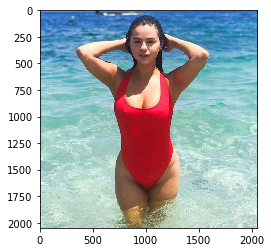

In [8]:
# https://stackoverflow.com/a/53403805/7437264
from PIL import Image
import numpy as np
from skimage import transform
def load(filename):
    np_image = Image.open(filename)
    np_image = np.array(np_image).astype('float32')/255
    np_image = transform.resize(np_image, (224, 224, 3))
    np_image = np.expand_dims(np_image, axis=0)
    img=mpimg.imread(filename)
    plt.imshow(img)
    return np_image

image = load("2.jpg")
ans = model.predict(image)
maping = {0 : "Neutral", 1 : "Porn", 2 : "Sexy"}
new_ans = np.argmax(ans[0])

print(maping[new_ans], np.round(ans,2))
print("With {} probability".format(ans[0][new_ans]))

# Summary
1. This Model unable to classify drawings and Anime as it is not trained for them.
2. It fails to classify Male genitalia because images in train data are mostly of females.
3. The accuracy can further be improved as I was limited by resources and don't have a GPU, so further training can increase accuracy.
4. Future Goals : To add bounded box with help or YOLO or Sliding window or any other object detection algo and classify video data live.